# XGB 개별적용 및 전진선택법을 통한 변수선택

In [1]:
import pandas as pd 
import numpy as np
import itertools
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('dataset/train.csv')
test =pd.read_csv('dataset/test.csv')

## NaN => 0으로 채우기

In [3]:
train = train.fillna(0)
test = test.fillna(0)

In [4]:
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


## Date column = datetime으로 

In [5]:
train['Date'] = pd.to_datetime(train['Date'],format=('%d/%m/%Y'))
test['Date'] = pd.to_datetime(test['Date'],format=('%d/%m/%Y'))

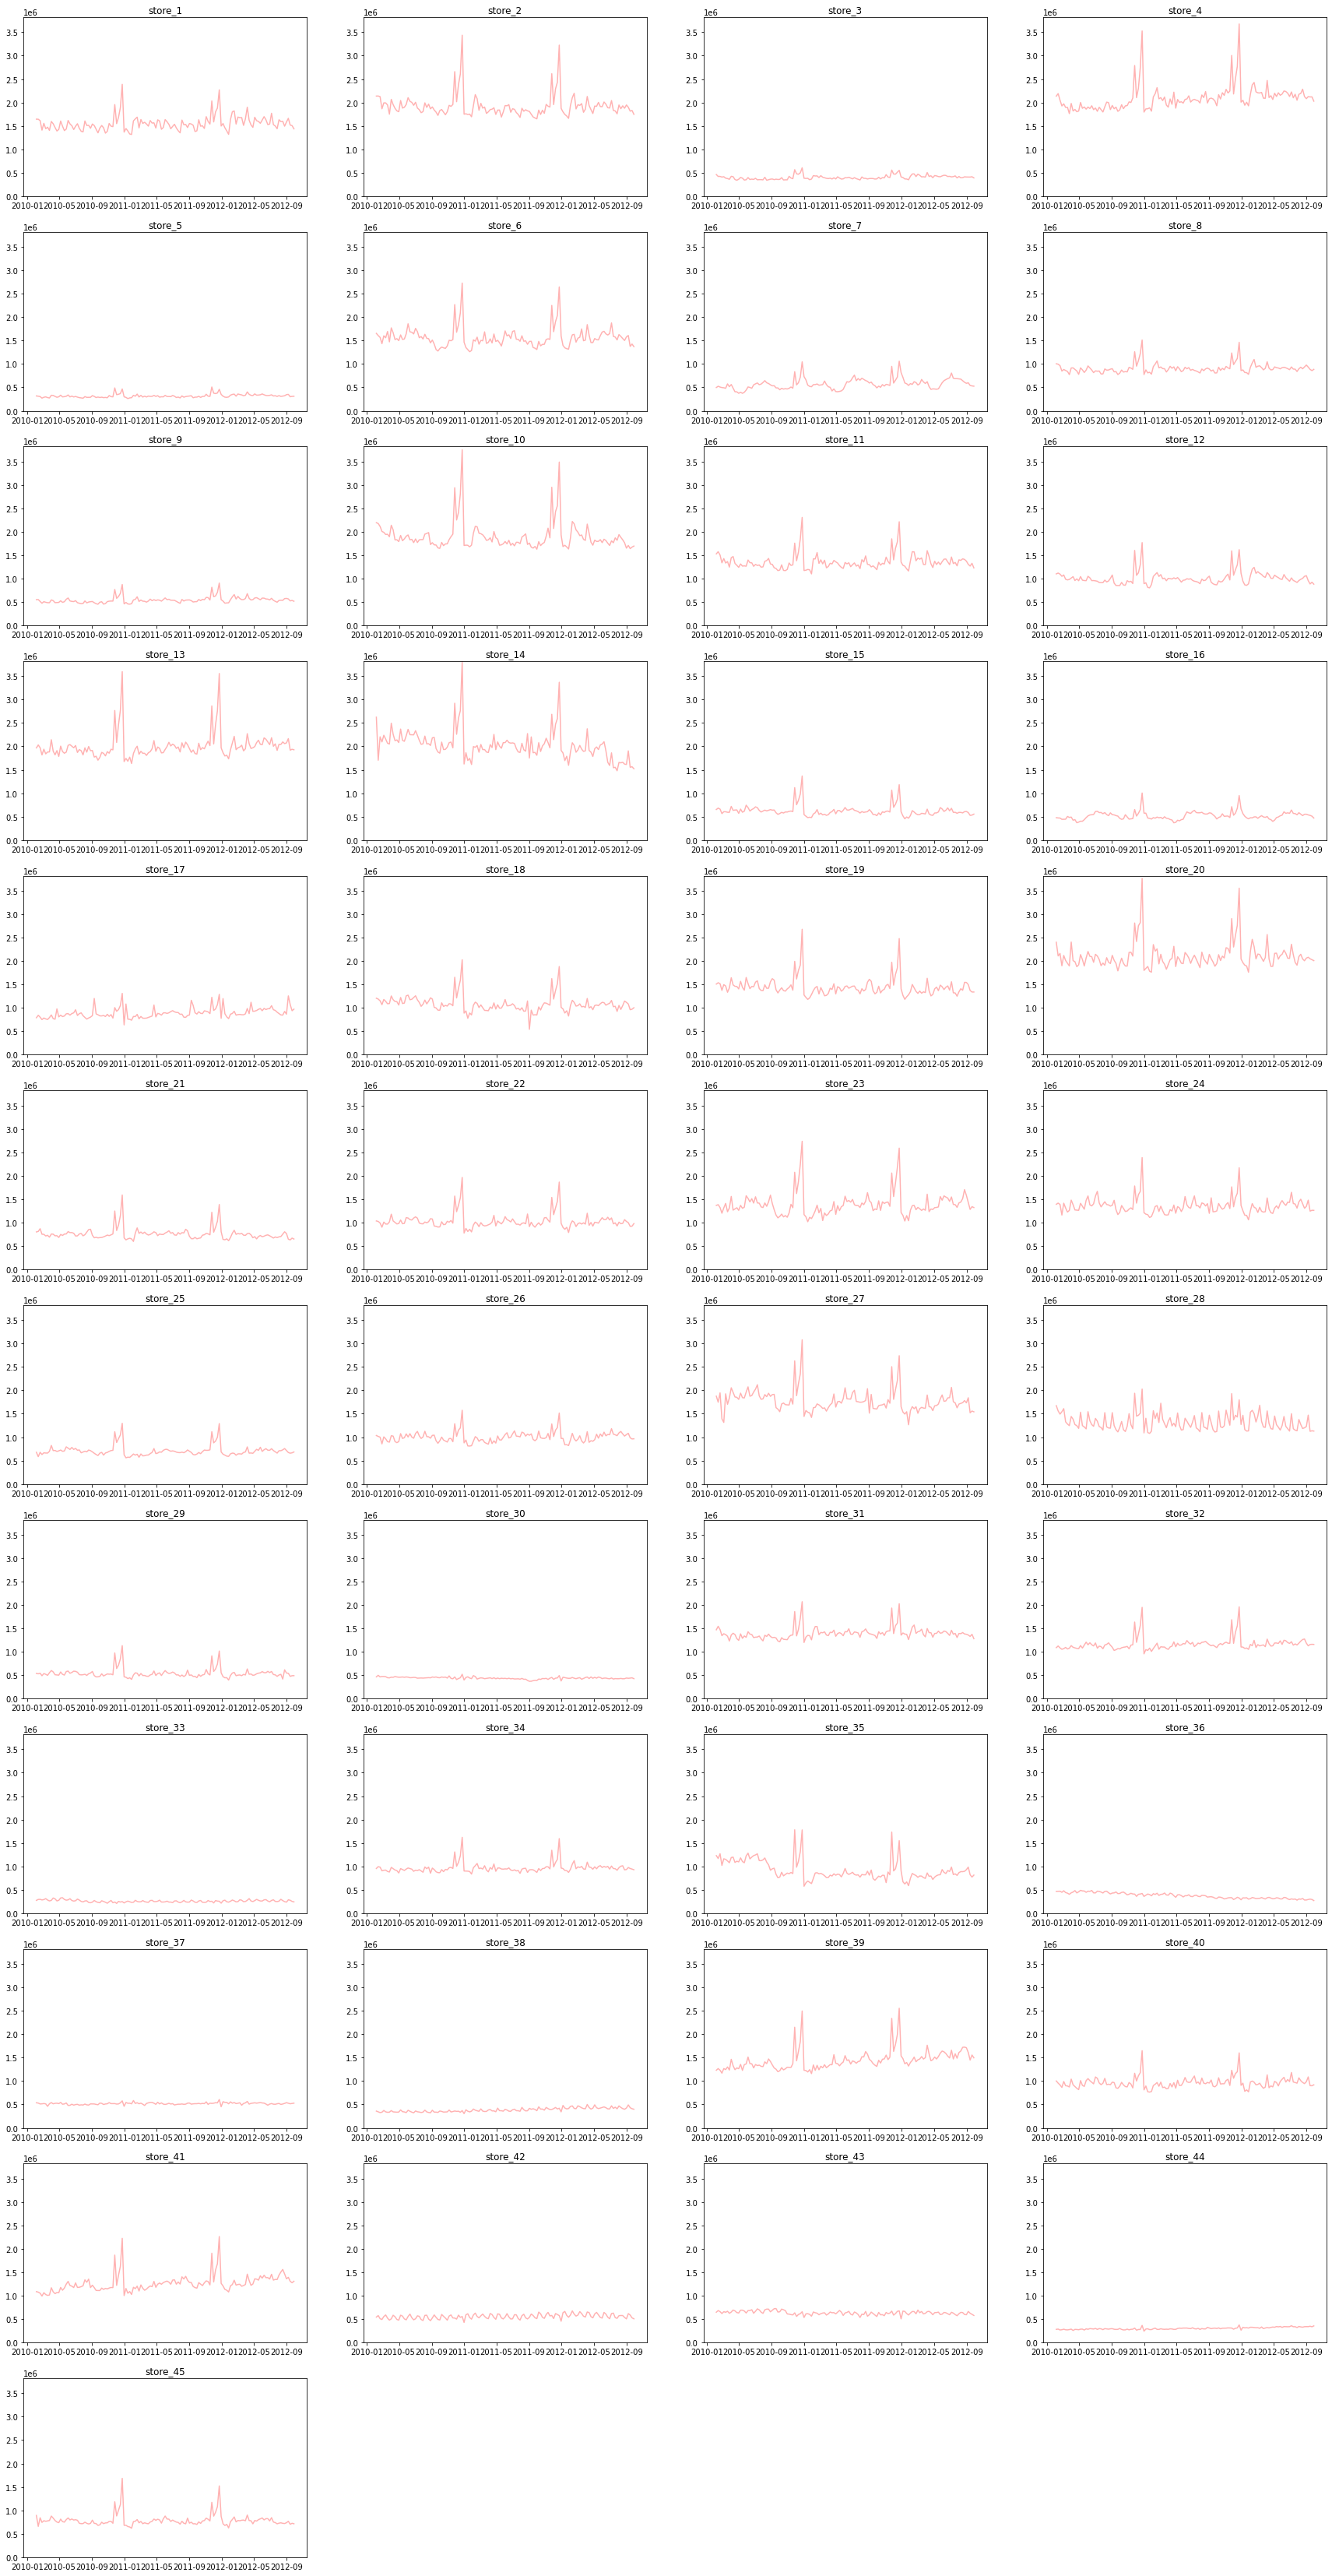

In [6]:
fig = plt.figure(figsize=(30,60))
max_sales = max(train.Weekly_Sales)
for store in range(1,max(train.Store)+1):
    storeset = train[train.Store==store]
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset.Date,storeset.Weekly_Sales, label="graph", alpha=0.3,color='r')
    plt.ylim(0, max_sales)
    
plt.show()
# 3,5,9,30,33,36,37,38,42,43,44 XGBRegressor 
# 나머지 = 시계열 분석을 해보는것이 어떨까? 


## IsHoliday => True = 0, False=1  원핫인코딩

In [7]:
train[['HF','HT']]=pd.get_dummies(train['IsHoliday'])
train.drop('IsHoliday',axis=1,inplace=True)

In [8]:
test[['HF','HT']] = [1,0]

In [9]:
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales,HF,HT
0,1,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,1643690.90,1,0
1,2,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,1641957.44,0,1
2,3,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,1611968.17,1,0
3,4,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,1409727.59,1,0
4,5,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,1554806.68,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,2012-08-31,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,734297.87,1,0
6251,6252,45,2012-09-07,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,766512.66,0,1
6252,6253,45,2012-09-14,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,702238.27,1,0
6253,6254,45,2012-09-21,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,723086.20,1,0


## 온도, 실업률, 연료 가격은 수치가 다르기 때문에 스케일링을 해주고 시작해야겠다.

In [10]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for Store in range(1,len(train['Store'].unique())+1):
    scale =MinMaxScaler()
    X_train_sc = train[train['Store']==Store][['Temperature','Fuel_Price','Unemployment']]
    X_train_Data = train[train['Store']==Store][['Store','Promotion1','Promotion2','Promotion3','Promotion4','Promotion5','HF','HT']]
    X_train_Data = X_train_Data.reset_index(level=None,drop=True)
    scale_data = pd.DataFrame(scale.fit_transform(X_train_sc))
    scale_data.columns = ['Temperature','Fuel_Price','Unemployment']
    X_train_Data[['Temperature','Fuel_Price','Unemployment']] = scale_data
    df_train = pd.concat([df_train,X_train_Data],axis=0)

    X_test_sc = test[test['Store']==Store][['Temperature','Fuel_Price','Unemployment']]
    X_test_Data = test[test['Store']==Store][['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5','HF','HT']]
    X_test_Data = X_test_Data.reset_index(level=None,drop=True)
    scale_test = pd.DataFrame(scale.transform(X_test_sc))
    scale_test.columns =['Temperature','Fuel_Price','Unemployment'] 
    X_test_Data[['Temperature','Fuel_Price','Unemployment']] = scale_test
    df_test = pd.concat([df_test,X_test_Data])

In [11]:
df_train = df_train.reset_index(level=None,drop=True)
df_test = df_test.reset_index(level=None,drop=True)

In [12]:
df_train['Weekly_Sales'] = train['Weekly_Sales']

## 전진 선택법 (변수를 효과좋은것들만) 

In [13]:
import statsmodels.api as sm

In [14]:
var = df_train.columns[1:-1].tolist()
y = df_train['Weekly_Sales']
select_var = [] 
sl_enter = 0.05 # 유의수준

sv_per_step = [] # 스텝별 선택된 변수들 
adjusted_r_squared = [] # 스텝별 수정된 결정계수 
steps =[] # 스텝 
step = 0  # 0부터 ~ 

while len(var) >0:
    remainder = list(set(var)- set(select_var))
    pval = pd.Series(index=remainder)
    
    for col in remainder:
        X= df_train[select_var+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
        
    min_pval = pval.min()
    if min_pval < sl_enter:
        select_var.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        r_squared = sm.OLS(y,sm.add_constant(df_train[select_var])).fit().rsquared_adj
        adjusted_r_squared.append(r_squared)
        sv_per_step.append(select_var.copy())
    else:
        break

C:\Users\medici\AppData\Local\Temp/ipykernel_716/3157734302.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\stat

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\medici\AppData\Local\Temp/ipykernel_716/3157734302.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\stat

In [15]:
select_var

['Promotion1',
 'Promotion3',
 'Promotion5',
 'Fuel_Price',
 'Promotion2',
 'Unemployment']

In [16]:
df_train1 = df_train[select_var]

In [17]:
df_train1['Store'] = df_train['Store']

C:\Users\medici\AppData\Local\Temp/ipykernel_716/2405193900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train1['Store'] = df_train['Store']


In [18]:
col1 = df_train1.columns[-1:].to_list()
col2 = df_train1.columns[:-1].to_list()
new =col1+col2
df_train= df_train1[new]
df_train

,Store,Promotion1,Promotion3,Promotion5,Fuel_Price,Promotion2,Unemployment
0,1,0.00,0.00,0.00,0.041637,0.00,1.000000
1,1,0.00,0.00,0.00,0.024408,0.00,1.000000
2,1,0.00,0.00,0.00,0.000000,0.00,1.000000
3,1,0.00,0.00,0.00,0.033740,0.00,1.000000
4,1,0.00,0.00,0.00,0.079684,0.00,1.000000
...,...,...,...,...,...,...,...
6250,45,23641.30,92.93,3992.13,0.854426,6.00,0.457746
6251,45,11024.45,52.63,2055.70,0.886613,12.80,0.457746
6252,45,11407.95,4.30,5268.92,0.913680,0.00,0.457746
6253,45,8452.20,63.24,8670.40,0.979517,92.28,0.457746


In [19]:
df_train['Weekly_Sales'] = train['Weekly_Sales']

C:\Users\medici\AppData\Local\Temp/ipykernel_716/2664056720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Weekly_Sales'] = train['Weekly_Sales']


In [20]:
df_test1 = df_test[select_var]
df_test1['Store'] = test['Store']
col1 = df_test1.columns[-1:].to_list()
col2 = df_test1.columns[:-1].to_list()
new =col1+col2
df_test= df_test1[new]
df_test

C:\Users\medici\AppData\Local\Temp/ipykernel_716/2607186530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['Store'] = test['Store']


,Store,Promotion1,Promotion3,Promotion5,Fuel_Price,Promotion2,Unemployment
0,1,8077.89,18.22,3626.14,0.791816,0.00,-0.279633
1,1,2086.18,8.11,5926.45,0.780330,0.00,-0.279633
2,1,950.33,4.93,2312.85,0.775305,0.00,-0.279633
3,1,2585.85,6.00,1305.01,0.712132,31.75,-0.279633
4,2,6037.76,10.04,3853.40,0.791816,0.00,-0.224559
...,...,...,...,...,...,...,...
175,44,38.65,0.98,457.74,0.924433,2.61,-0.070059
176,45,5046.74,18.82,2340.01,0.940746,0.00,0.427817
177,45,1956.28,7.89,3990.54,0.951719,0.00,0.427817
178,45,2004.02,3.18,1537.49,0.929042,0.00,0.427817


<AxesSubplot:>

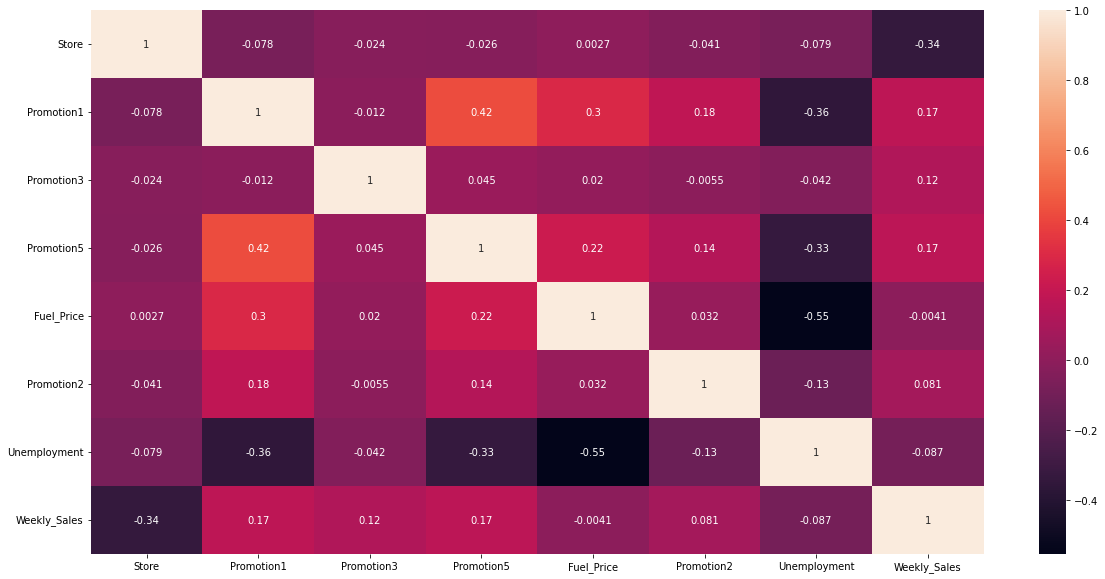

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train.corr(),annot=True)

In [22]:
result = []
for Store in range(1,len(df_train['Store'].unique())+1):
    model = XGBRegressor()
    train_X = df_train[df_train['Store']==Store].iloc[:,1:-1]
    train_y = df_train[df_train['Store']==Store].iloc[:,-1]
    model.fit(train_X,train_y)
    test_X = df_test[df_test['Store']==Store].iloc[:,1:]
    pred= model.predict(test_X)
    result.append(pred)

In [23]:
result

[array([1575054.8, 1461049.2, 1450348.9, 1588895.1], dtype=float32),
 array([1786588.6, 1833170.1, 1776462.6, 1819536.2], dtype=float32),
 array([407902.22, 405197.4 , 392753.2 , 394917.97], dtype=float32),
 array([2157725. , 2127400.5, 2126628. , 2115340.5], dtype=float32),
 array([319972.7 , 302765.3 , 300287.62, 311439.78], dtype=float32),
 array([1498964.9, 1386461.2, 1451472.5, 1535332.2], dtype=float32),
 array([514368.28, 563061.3 , 591979.  , 679654.9 ], dtype=float32),
 array([934288.  , 865608.3 , 892586.8 , 923557.56], dtype=float32),
 array([537893.1 , 550767.1 , 552670.56, 545176.8 ], dtype=float32),
 array([1755816.8, 1714845. , 1841438.9, 1788425.2], dtype=float32),
 array([1379033.9, 1286934.8, 1309646.6, 1350825.6], dtype=float32),
 array([ 991520.56,  901886.  ,  939759.  , 1017741.75], dtype=float32),
 array([2029702.2, 1850498.2, 1925515.4, 2199393. ], dtype=float32),
 array([1652717.1, 1803542.1, 1561856.5, 1595817. ], dtype=float32),
 array([546282.06, 528585.9 , 

In [24]:
result = list(itertools.chain(*np.around(result,2)))

In [25]:
result

[1575054.8,
 1461049.2,
 1450348.8,
 1588895.2,
 1786588.6,
 1833170.1,
 1776462.5,
 1819536.4,
 407902.2,
 405197.4,
 392753.2,
 394917.97,
 2157725.0,
 2127400.5,
 2126628.0,
 2115340.5,
 319972.7,
 302765.3,
 300287.62,
 311439.78,
 1498964.8,
 1386461.2,
 1451472.5,
 1535332.4,
 514368.28,
 563061.3,
 591979.0,
 679654.9,
 934288.0,
 865608.3,
 892586.8,
 923557.6,
 537893.1,
 550767.1,
 552670.56,
 545176.8,
 1755816.8,
 1714845.0,
 1841438.9,
 1788425.2,
 1379033.9,
 1286934.8,
 1309646.6,
 1350825.6,
 991520.56,
 901886.0,
 939759.06,
 1017741.75,
 2029702.2,
 1850498.2,
 1925515.4,
 2199393.0,
 1652717.1,
 1803542.1,
 1561856.5,
 1595817.0,
 546282.06,
 528585.9,
 547547.7,
 625636.56,
 483519.97,
 581523.6,
 529322.7,
 547741.56,
 920540.4,
 948137.94,
 944982.8,
 946396.06,
 1018216.75,
 1007649.75,
 982866.9,
 1084857.4,
 1321160.5,
 1459488.4,
 1359919.6,
 1401166.5,
 1939316.4,
 1967700.5,
 1864426.9,
 2018234.1,
 720684.25,
 722585.4,
 708016.56,
 772645.94,
 939969.2,
 1